### Task 3: Model Implementation and Comparison (RNN, LSTM, BiLSTM)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

In [2]:
# load the data
df = pd.read_csv('preprocessed_youtube_comments.csv')
print(f"Dataset Shape: {df.shape}")

label_map = {-1: 0, 0: 1, 1: 2}
df['label'] = df['sentiment'].map(label_map)

# Use processed_comment for training
X = np.array(df['processed_comment'].astype(str).tolist())
y = np.array(df['label'].tolist())

Dataset Shape: (64208, 6)


In [ ]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# tokenization and Padding
max_words = 5000
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# saving tokenizer for later use in prediction
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# helper for plotting
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.show()

learning_rate = 1e-3
embedding_dim = 64

def get_callbacks(lr_patience=2):
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=lr_patience,
        min_lr=1e-6,
        verbose=1
    )
    return [early_stop, reduce_lr]

### Model 1 - RNN

Epoch 1/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3765 - loss: 1.0944 - val_accuracy: 0.3658 - val_loss: 1.0830 - learning_rate: 0.0010
Epoch 2/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3779 - loss: 1.0858 - val_accuracy: 0.3960 - val_loss: 1.0773 - learning_rate: 0.0010
Epoch 3/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3837 - loss: 1.0839 - val_accuracy: 0.3965 - val_loss: 1.0795 - learning_rate: 0.0010
Epoch 4/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3848 - loss: 1.0850 - val_accuracy: 0.3841 - val_loss: 1.0809 - learning_rate: 0.0010
Epoch 5/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3827 - loss: 1.0826 - val_accuracy: 0.3710 - val_loss: 1.0763 - learning_rate: 0.0010
Epoch 6/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3830 - loss: 1.0804 - val_accuracy: 0.3961 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 7/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.385

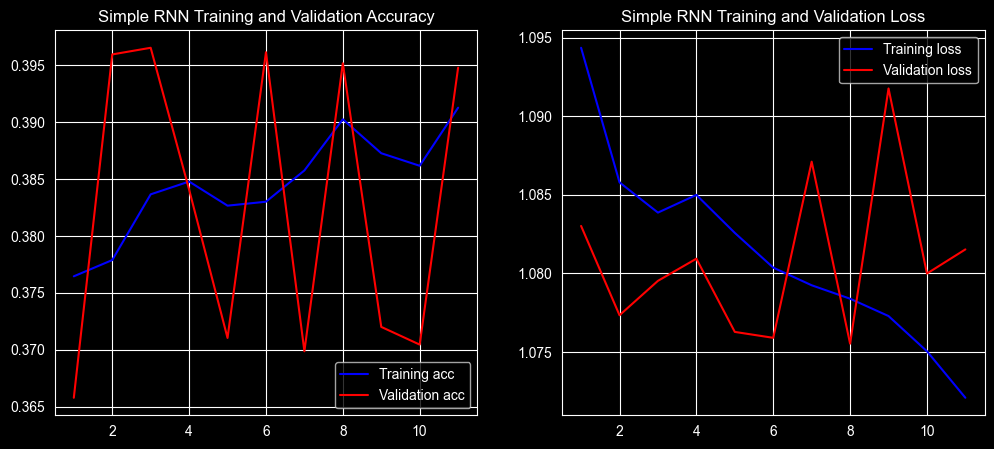

In [6]:
model_rnn = Sequential([
    Embedding(max_words, embedding_dim),
    SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model_rnn.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
 )

history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=get_callbacks(lr_patience=3)
 )
plot_history(history_rnn, 'Simple RNN')

### Model 2 - LSTM

Epoch 1/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3916 - loss: 1.0788 - val_accuracy: 0.3965 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 2/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.5760 - loss: 0.8802 - val_accuracy: 0.6552 - val_loss: 0.7957 - learning_rate: 0.0010
Epoch 3/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.7433 - loss: 0.6614 - val_accuracy: 0.7977 - val_loss: 0.5797 - learning_rate: 0.0010
Epoch 4/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.8101 - loss: 0.5416 - val_accuracy: 0.8232 - val_loss: 0.5244 - learning_rate: 0.0010
Epoch 5/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.8301 - loss: 0.4937 - val_accuracy: 0.8279 - val_loss: 0.5147 - learning_rate: 0.0010
Epoch 6/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.8391 - loss: 0.4702 - val_accuracy: 0.8260 - val_loss: 0.5238 - learning_rate: 0.0010
Epoch 7/15
1444/1445 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accurac

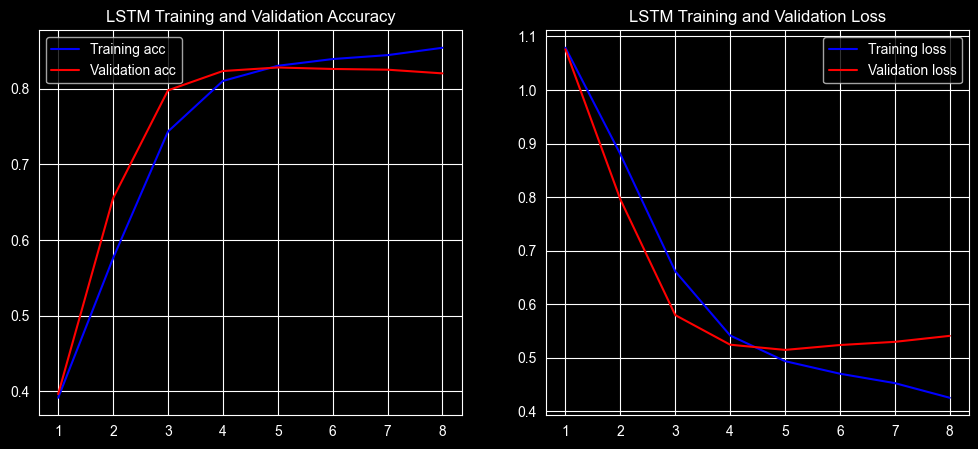

In [7]:
model_lstm = Sequential([
    Embedding(max_words, embedding_dim),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model_lstm.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
 )
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=get_callbacks(lr_patience=2)
 )
plot_history(history_lstm, 'LSTM')

### Model 3 - Bidirectional LSTM

Epoch 1/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.7099 - loss: 0.7180 - val_accuracy: 0.8149 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 2/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.8193 - loss: 0.5329 - val_accuracy: 0.8254 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 3/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8311 - loss: 0.4987 - val_accuracy: 0.8303 - val_loss: 0.5157 - learning_rate: 0.0010
Epoch 4/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.8372 - loss: 0.4786 - val_accuracy: 0.8279 - val_loss: 0.5054 - learning_rate: 0.0010
Epoch 5/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.8425 - loss: 0.4623 - val_accuracy: 0.8279 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 6/15
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8521 - loss: 0.4388
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 58s 40ms/step - accuracy

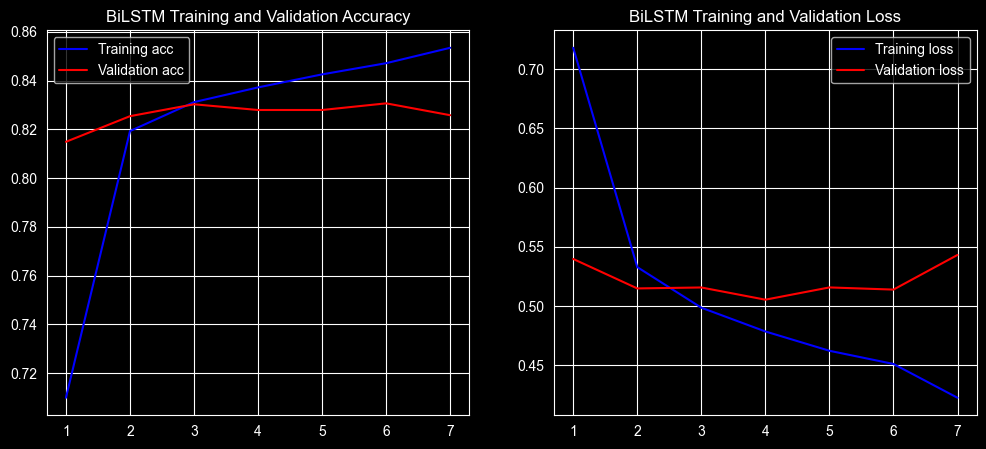

In [8]:
model_bilstm = Sequential([
    Embedding(max_words, embedding_dim),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_bilstm.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
 )

history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=get_callbacks(lr_patience=2)
 )
plot_history(history_bilstm, 'BiLSTM')

### Evaluation & Comparison

402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

 Simple RNN Classification Report
              precision    recall  f1-score   support

    Negative       0.41      0.00      0.01      3102
     Neutral       0.00      0.00      0.00      4702
    Positive       0.39      1.00      0.56      5038

    accuracy                           0.39     12842
   macro avg       0.27      0.33      0.19     12842
weighted avg       0.25      0.39      0.22     12842



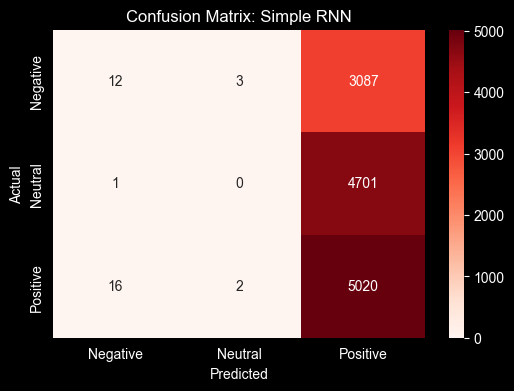

402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 LSTM Classification Report
              precision    recall  f1-score   support

    Negative       0.82      0.72      0.76      3102
     Neutral       0.76      0.94      0.84      4702
    Positive       0.88      0.76      0.82      5038

    accuracy                           0.82     12842
   macro avg       0.82      0.81      0.81     12842
weighted avg       0.82      0.82      0.81     12842



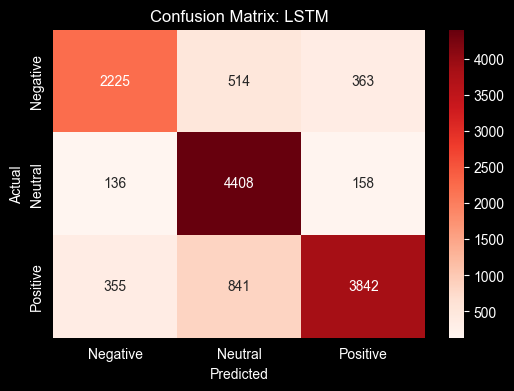

402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 BiLSTM Classification Report
              precision    recall  f1-score   support

    Negative       0.83      0.73      0.78      3102
     Neutral       0.76      0.93      0.84      4702
    Positive       0.88      0.77      0.82      5038

    accuracy                           0.82     12842
   macro avg       0.83      0.81      0.81     12842
weighted avg       0.83      0.82      0.82     12842



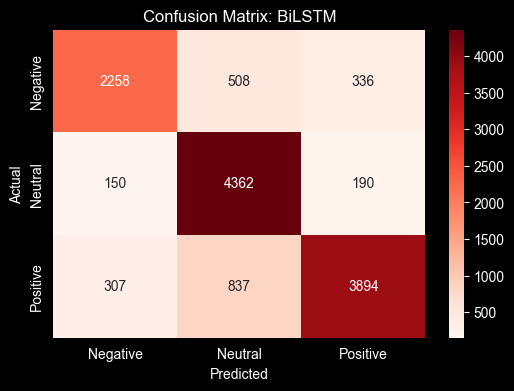

In [9]:
models = {'Simple RNN': model_rnn, 'LSTM': model_lstm, 'BiLSTM': model_bilstm}
results = []

for name, model in models.items():
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})
    print(f"\n {name} Classification Report")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
    
    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

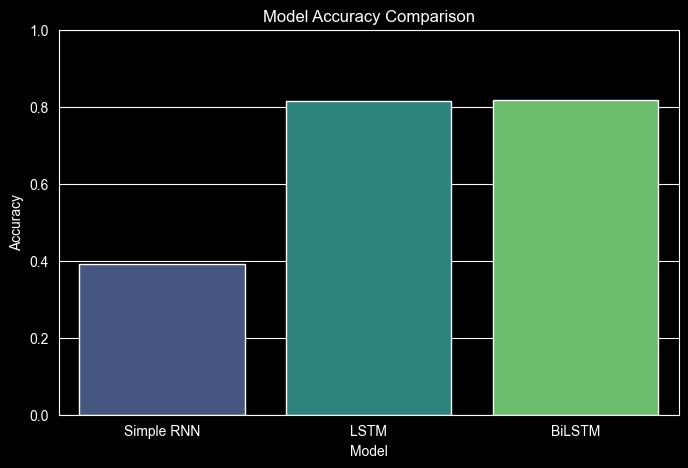

In [10]:
# visual comparison
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', hue='Model', data=results_df, palette='viridis', legend=False)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

In [11]:
# all model test accuracy
test_loss, test_accuracy = model_rnn.evaluate(X_test, y_test, verbose=0)
print(f"RNN Test Accuracy: {test_accuracy}")

test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Accuracy: {test_accuracy}")

test_loss, test_accuracy = model_bilstm.evaluate(X_test, y_test, verbose=0)
print(f"BiLSTM Test Accuracy: {test_accuracy}")

RNN Test Accuracy: 0.39183926582336426
LSTM Test Accuracy: 0.8156828880310059
BiLSTM Test Accuracy: 0.8187198042869568


In [ ]:
model_bilstm.save('sentiment_bilstm_model.keras')